
# Convolutional Neural Network CNN
1. Using Word2Vec implementing CNN model
2. Dispaly Confusion Matrix, precision, recall and F1-score
3. Display few prediction using predict module. 
4. Get 10-fold Average of the CNN model.

In [101]:
from __future__ import division, print_function

# dataframe
import pandas as pd

# numpy array
import numpy as np

# figures visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import seaborn as sns

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

# word2vec
import gensim 
from gensim import models
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

# CNN model and keras preprocessing
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Conv2D, GlobalMaxPooling2D
from keras.models import Sequential
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# nltk data preprocessing
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize 
from nltk.stem import WordNetLemmatizer

# stopword - remove buzz word
from nltk.corpus import stopwords

# splitting data
from sklearn.model_selection import train_test_split

# punctuation - data imbalance
import collections
import re
import string

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

In [102]:
# original hindi file
filename  = 'Eng-Hin-data/hindi-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']

In [103]:
orig_df.head

<bound method NDFrame.head of                                                    Text  Label
0     'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #Is...      2
1        '@SanjayGadhiaINC @IndiaToday18 अज़ाबे इलाही 👍      1
2     'आखिर अब #सुशांत_सिंह_राजपूत जी को न्याय मिल ज...      0
3     'अमीन के 500 से अधिक छात्रों ने सर्वे भवन के ग...      0
4     '@deoriapolice @Uppolice @myogiadityanath @spg...      0
...                                                 ...    ...
8788                  '@atullondhe राहुल गांधी जिंदाबाद      0
8789  'पैगंबर हज़रत मुहम्मद सल्लल्लाहु अलैहि वसल्लम ...      1
8790  'कर्नाटक बेंगलुरू में अल्लाह मोहम्मद गांडू के ...      2
8791  'अच्छी खबर है ऐसे एक एक कर सभी जेहादी भारतीय फ...      2
8792  '@Ruzena__Malik जनता चाइना से दीवाली की लड़ी ख...      0

[8793 rows x 2 columns]>

In [104]:
orig_df.Text[6]

"'आज के दिन ही मेरा क्रिकेट प्रेम भी समाप्त हो गया"

In [105]:
df["Text"] = orig_df["Text"].astype(str)
df["Label"] = orig_df["Label"].astype(str)

### Class count

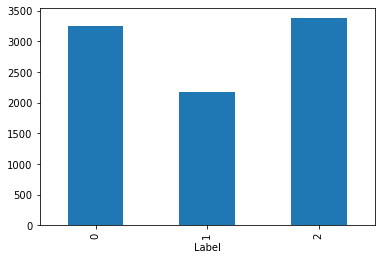

In [106]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [107]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3375
0    3244
1    2174
Name: Label, dtype: int64

### Balancing Data

In [108]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [109]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])

In [110]:
data = pd.DataFrame(new_text)
data.columns = ['Text']
data['Label'] = new_label
data = pd.concat([df, data])

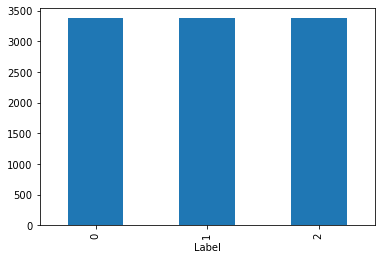

In [111]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [112]:
data.Label.value_counts()

2    3375
1    3374
0    3374
Name: Label, dtype: int64

In [113]:
data=data.sample(frac=1).reset_index(drop=True)
data

,Text,Label
0,'@007AliSohrab मदनी साहब उनके नाम के आगे रहमतु...,1
1,'यजीद वो जो जिलतो का नाम हो गया हुसैन (आ स )...,1
2,'अल्लाह हु अकबर और बिश्मिल्लाह बोलकर गला काटन...,2
3,'@SalmanNizami_ साला जेहादी बकबास कर रहा,2
4,'धोनी के सन्यास से भारतीय क्रिकेट को अपूरणीय छ...,0
...,...,...
10118,'ईनको ईकठ्ठे करती है मस्जिद जहाँ पर होता है दे...,2
10119,'बस यही देख कल धोनी और रैना ने क्रिकेट से सन्य...,0
10120,'भीम आर्मी जिन्दाबाद #Casteist_Kangana,0
10121,'@dr_kafeel_ वालेकुम अस्सलाम अल्लाह आपकी परेश...,1


### Data Preprocessing

In [115]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r"\*", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Text'] = data['Text'].apply(lambda x: textPattern(x))

In [116]:
data.shape

(10123, 2)

In [117]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Text]

In [118]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [119]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [120]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [121]:
# Removing Stopwords
stoplist=open("Devanagari/stopwords.txt","r")

In [122]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [123]:
zero  = []
one = []
two = []
for l in data.Label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
        two.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        two.append(0)
    elif l == '2':
        zero.append(0)
        one.append(0)
        two.append(1)
        
data['0']= zero
data['1']= one
data['2']= two

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2']]

In [124]:
category_id = []
for l in data.Label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
    elif l == '2':
        category_id.append('2')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2', 'Category_id' ]]
data.head(25)

,Text_Final,tokens,Label,0,1,2,Category_id
0,007alisohrab मदनी साहब उनके नाम के आगे रहमतुल्...,"[007alisohrab, मदनी, साहब, उनके, नाम, के, आगे,...",1,0,1,0,1
1,यजीद वो जो जिलतो का नाम हो गया हुसैन ( आ स ) व...,"[यजीद, वो, जो, जिलतो, का, नाम, हो, गया, हुसैन,...",1,0,1,0,1
2,अल्लाह हु अकबर और बिश्मिल्लाह बोलकर गला काटने ...,"[अल्लाह, हु, अकबर, और, बिश्मिल्लाह, बोलकर, गला...",2,0,0,1,2
3,salmannizami_ साला जेहादी बकबास कर रहा,"[salmannizami_, साला, जेहादी, बकबास, कर, रहा]",2,0,0,1,2
4,धोनी के सन्यास से भारतीय क्रिकेट को अपूरणीय छत...,"[धोनी, के, सन्यास, से, भारतीय, क्रिकेट, को, अप...",0,1,0,0,0
5,भारतीय क्रिकेट को इन नए आयाम तक पहुंचाने वाले ...,"[भारतीय, क्रिकेट, को, इन, नए, आयाम, तक, पहुंचा...",0,1,0,0,0
6,मेरी रूह में नाम ए अहमद बसा हो । मेरी धड़कनों ...,"[मेरी, रूह, में, नाम, ए, अहमद, बसा, हो, ।, मेर...",1,0,1,0,1
7,लोगों का कहना है की महेंद्रसिंह धोनी इस विकेटक...,"[लोगों, का, कहना, है, की, महेंद्रसिंह, धोनी, इ...",0,1,0,0,0
8,# माशा_अल्लाह ये मुसलमान गरीब ज़रूर है मगर ईमा...,"[#, माशा_अल्लाह, ये, मुसलमान, गरीब, ज़रूर, है,...",1,0,1,0,1
9,vinodkapri तुम्हे पता नहीं आजकल हिन्दुओं ने पा...,"[vinodkapri, तुम्हे, पता, नहीं, आजकल, हिन्दुओं...",2,0,0,1,2


In [125]:
data = data[data.tokens != '']

In [126]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 10 % for testing. We use random state so every time we get the same training and testing data.

In [127]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)


In [128]:
# # total training words
totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

# # Storing Length of the training sentence
lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

# # training Vocabulary size
trainingVocabSize = sorted(list(set(totalTrainingWords)))

## Total number of lines
linesCount = len(data_train["tokens"])

### Load Google News Glove model

In [131]:
# Run only once
# Convert Glove file to word2vec format 
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'glove.6B.300d.txt'  # I unzipped in glove.6B subdirectory 
word2vec_output_file = 'glove.6B.300d.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 300)

In [132]:
# Use the converted Glove file
filename = 'glove.6B.300d.word2vec'
word2vec = KeyedVectors.load_word2vec_format(filename, binary=False)

In [133]:
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 300


### Tokenize and Pad sequences

In [134]:
tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 19134 unique tokens.


In [135]:
cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [136]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(19135, 300)


In [137]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)

### Define CNN

The model is from the paper 'Convolutional Neural Networks for Sentence Classification' we have updated the network according to our requirement [1]

In [138]:
label_names = ['0', '1', '2']

In [139]:
def ConvolutionalNeuralNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    # Embedding layer
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    
    #Kernal (window) size
    filter_sizes = [2,3,4,5]

    # Convolution Layer and max-pooling
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=512, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
        
    l_merge = concatenate(convs, axis=1)
    
    # softmax layer for multiclass identification 
    x = Dropout(0.1)(l_merge)  
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss= 'categorical_crossentropy',
                 optimizer = keras.optimizers.RMSprop(learning_rate=1e-3),
#                    optimizer='adam',
                  metrics=['accuracy'])
    return model

In [140]:
# Splitting train data into X_train and y_train
y_train = data_train[label_names].values
x_train = cnnTrainData
y_tr = y_train

In [141]:
# Splitting train data into X_test and y_test
y_test = data_test[label_names].values
x_test = cnnTestData
y_tst = y_test

In [142]:
model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

In [143]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 300)     5740500     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 149, 512)     307712      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 148, 512)     461312      embedding_1[0][0]                
____________________________________________________________________________________________

### Train CNN

In [144]:
num_epochs = 10
batch_size = 512

In [145]:
history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/10
17/17 [==============================] - 48s 3s/step - loss: 5.7274 - accuracy: 0.3815 - val_loss: 2.1504 - val_accuracy: 0.3502
Epoch 2/10
17/17 [==============================] - 47s 3s/step - loss: 1.1000 - accuracy: 0.4946 - val_loss: 1.4281 - val_accuracy: 0.4248
Epoch 3/10
17/17 [==============================] - 46s 3s/step - loss: 0.9435 - accuracy: 0.5770 - val_loss: 0.7738 - val_accuracy: 0.6905
Epoch 4/10
17/17 [==============================] - 47s 3s/step - loss: 0.8172 - accuracy: 0.6613 - val_loss: 0.6248 - val_accuracy: 0.7761
Epoch 5/10
17/17 [==============================] - 47s 3s/step - loss: 0.5657 - accuracy: 0.7801 - val_loss: 0.4501 - val_accuracy: 0.8353
Epoch 6/10
17/17 [==============================] - 47s 3s/step - loss: 0.4289 - accuracy: 0.8385 - val_loss: 0.4796 - val_accuracy: 0.8057
Epoch 7/10
17/17 [==============================] - 47s 3s/step - loss: 0.3292 - accuracy: 0.8725 - val_loss: 0.4242 - val_accuracy: 0.8573
Epoch 8/10
17/17 [==

In [146]:
# evaluate on test data
results = model.evaluate(x_test, y_tst)

32/32 [==============================] - 3s 83ms/step - loss: 0.3331 - accuracy: 0.8924


In [147]:
# predict model
predictions = model.predict(cnnTestData, batch_size=1024, verbose=1)

1/1 [==============================] - 0s 2ms/step


### Testing few sentences using our model

In [148]:

labels = ['0', '1', '2']

def makeprediction(texts):
    tk = Tokenizer()
    tk.fit_on_texts(texts)
    index_list = tk.texts_to_sequences(texts)
    x_train = pad_sequences(index_list, maxlen=150)
    pred = model.predict(x_train)
    print(pred)
    result = labels[np.argmax(pred)]
    return result

In [149]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [150]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.8923988153998026

In [151]:
data_test.Label.value_counts()

2    353
0    336
1    324
Name: Label, dtype: int64

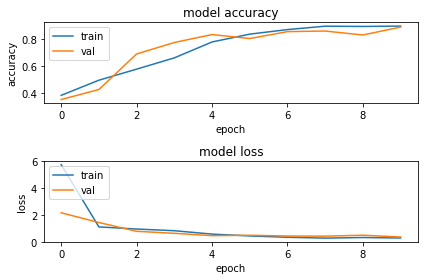

In [152]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [153]:
results = confusion_matrix(data_test.Label, prediction_labels)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(data_test.Label, prediction_labels))
print ('Report : ')
print (classification_report(data_test.Label, prediction_labels))

Confusion Matrix :
[[272  60   4]
 [  3 320   1]
 [  6  35 312]]
Accuracy Score : 0.8923988153998026
Report : 
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       336
           1       0.77      0.99      0.87       324
           2       0.98      0.88      0.93       353

    accuracy                           0.89      1013
   macro avg       0.91      0.89      0.89      1013
weighted avg       0.91      0.89      0.89      1013



                        Convolution Neural Network


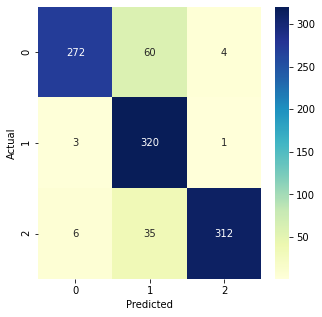

In [154]:
from sklearn.metrics import confusion_matrix
print("                        Convolution Neural Network")
conf_mat = confusion_matrix(data_test.Label, prediction_labels)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Testing CNN using KFold cross validation

In [155]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import zscore
from sklearn import metrics
import tensorflow as tf
import random

f_score=[]
fold = 10
label_names = ['0', '1', '2']
num_epochs = 5
batch_size = 32
#oos_y = []
#oos_pred = []
results = []
#for train, test in kf.split(data["tokens"], data['Label']):

for i in range(fold):
    print("Fold: ", i+1)
    random_num = np.random.randint(1,7000, 1)[0]
    data_train, data_test = train_test_split(data, test_size=0.10, shuffle = True, random_state = random_num)

    # # total training words
    totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

    # # Storing Length of the training sentence
    lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

    # # training Vocabulary size
    trainingVocabSize = sorted(list(set(totalTrainingWords)))

    ## Total number of lines
    linesCount = len(data_train["tokens"])
    
    tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
    tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
    training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

    train_word_index = tokenizer.word_index
    cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
    
    for word,index in train_word_index.items():
        train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
        
    test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
    cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)
    
    # Splitting train data into X_train and y_train
    y_train = data_train[label_names].values
    x_train = cnnTrainData
    y_tr = y_train
    
    # Splitting train data into X_test and y_test
    y_test = data_test[label_names].values
    x_test = cnnTestData
    y_tst = y_test
    
    # create model
    model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))
    
    #Train Model
    history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)
      
    # model evaluate
    
    print("Results for current fold:")
    results.append(model.evaluate(x_test, y_tst, batch_size=128))

model.save('model_CNN.h5')    

Fold:  1
Epoch 1/5
257/257 [==============================] - 62s 242ms/step - loss: 0.8253 - accuracy: 0.7416 - val_loss: 0.2339 - val_accuracy: 0.9067
Epoch 2/5
257/257 [==============================] - 61s 239ms/step - loss: 0.2852 - accuracy: 0.9000 - val_loss: 0.3579 - val_accuracy: 0.8716
Epoch 3/5
257/257 [==============================] - 62s 240ms/step - loss: 0.2176 - accuracy: 0.9230 - val_loss: 0.3266 - val_accuracy: 0.8913
Epoch 4/5
257/257 [==============================] - 61s 238ms/step - loss: 0.1923 - accuracy: 0.9351 - val_loss: 0.2144 - val_accuracy: 0.9440
Epoch 5/5
257/257 [==============================] - 61s 237ms/step - loss: 0.1842 - accuracy: 0.9399 - val_loss: 0.5561 - val_accuracy: 0.8650
Results for current fold:
8/8 [==============================] - 2s 235ms/step - loss: 0.6243 - accuracy: 0.8401
Fold:  2
Epoch 1/5
257/257 [==============================] - 61s 238ms/step - loss: 0.8951 - accuracy: 0.7281 - val_loss: 0.4668 - val_accuracy: 0.8332
Epoch

In [156]:
import statistics 

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.9169792771339417


In [157]:
# Prediction 
# translator
translator = Translator()

In [158]:
# 0
texts = ["Sachin: Once there was a fight between Yusuf and Bhajji. Sehwag: Paji, was he Muhammad Yusuf or Yusuf Youhana at that time. This man will not let him live even after retirement."]
print(makeprediction(texts))

[[2.9339091e-04 1.5317675e-01 8.4652984e-01]]
2


In [159]:
# 2
texts = ["@_ROB_29 If this was a Muslim girl in Afghanistan you'd call her a terrorist"]
print(makeprediction(texts))

[[9.8361164e-10 2.7067533e-16 1.0000000e+00]]
2


In [160]:
# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
texts = [trans.text]
print('Predicted Label: ',makeprediction(texts))

Hindi:  'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂
Translated: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂
[[4.4471758e-08 8.0531137e-09 1.0000000e+00]]
Predicted Label:  2


In [161]:
# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
texts = [trans.text]
print('Predicted Label: ',makeprediction(texts))

Hindi:   समाज वादी  पार्टी  जिंदाबाद 
Translated: Samajwadi Party Zindabad
[[9.9957353e-01 1.2733868e-05 4.1374486e-04]]
Predicted Label:  0


In [162]:
# 1
hin_text =  "इसलाम सुंदर है"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
texts = [trans.text]
print('Predicted Label: ',makeprediction(texts))

Hindi:  इसलाम सुंदर है
Translated: Islam is beautiful
[[9.9957353e-01 1.2733868e-05 4.1374486e-04]]
Predicted Label:  0


### Reference
[1] "Convolutional Neural Networks for Sentence Classification" by Yoon Kim
